In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm

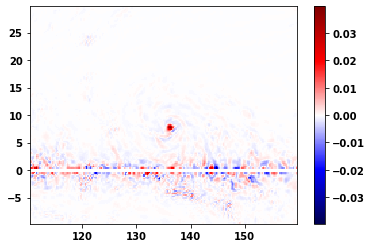

In [2]:
gvort = np.load("./DATA/gvort.20131105-20131107.hourly.500hPa.npy") # date, lat, lon
lats  = np.load("./DATA/latitude.npy") # lat, lon
lons  = np.load("./DATA/longitude.npy") # lat, lon
dates = pd.date_range(start = "2013-11-05 00:00", end = "2013-11-07 23:00",\
                      freq = "H")

date    = "2013-11-06 12:00:00"
dateIdx = np.where(dates == date)[0][0]

gvort = gvort[dateIdx]

gvort[np.isinf(gvort) == True] = np.nan

absMax = np.nanmax(np.abs(gvort))
plot = plt.pcolor(lons, lats, gvort, cmap = "seismic",\
                  vmin = -absMax, vmax = absMax)

plt.colorbar(plot)

Threshold Vorticity: -4.119966e-05


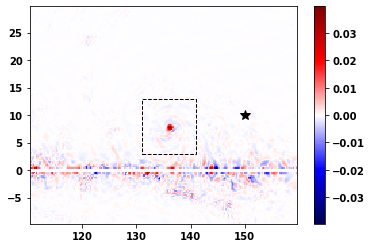

In [3]:
latThre, lonThre =  10., 150.
lllat  , urlat   =   3.,  13.
lllon  , urlon   = 131., 141.

threshold = gvort[np.where(lats == latThre)[0][0], np.where(lons == lonThre)[0][0]]
print("Threshold Vorticity: %e" % threshold)

fig, sub = plt.subplots()

plot = sub.pcolor(lons, lats, gvort, cmap = "seismic",\
           vmin = -absMax, vmax = absMax)
sub.plot(lonThre, latThre, marker = "*", c = "k", ms = 10)
sub.add_patch(Rectangle((lllon, lllat), urlon - lllon, urlat - lllat,\
                        fill = None, ls = "--"))

fig.colorbar(plot)

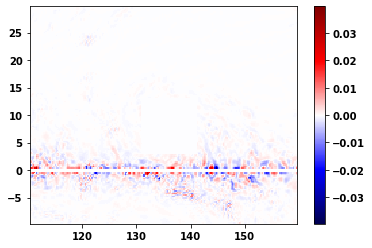

In [4]:
typhoonWO = np.full(gvort.shape, np.nan, dtype = float)

latList = lats[:, 0]
lonList = lons[0, :]

for j, lat in enumerate(latList):
    for i, lon in enumerate(lonList):
        if (lat >= lllat) & (lat <= urlat) & (lon >= lllon) & (lon <= urlon):
            if (gvort[j, i] != threshold):
                typhoonWO[j, i] = threshold
            else:
                typhoonWO[j, i] = gvort[i, j]
        else:
            typhoonWO[j, i] = gvort[j, i]
            
plot = plt.pcolor(lons, lats, typhoonWO, cmap = "seismic",\
                  vmin = -absMax, vmax = absMax)

plt.colorbar(plot)

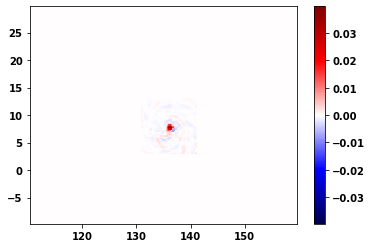

In [5]:
typhoonW = gvort - typhoonWO

plot = plt.pcolor(lons, lats, typhoonW, cmap = "seismic",\
           vmin = -absMax, vmax = absMax)

plt.colorbar(plot)

In [39]:
def dist(lon1, lat1, lon2, lat2):
    lon1 = radians(lon1)
    lat1 = radians(lat1)
    lon2 = radians(lon2)
    lat2 = radians(lat2)
    
    dlon = np.abs(lon2 - lon1)
    dlat = np.abs(lat2 - lat1)
    
    a = sin(dlat / 2.) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2.) ** 2
    c = 2. * atan2(sqrt(a), sqrt(1. - a))
    
    return 6373000. * c

In [40]:
def Jacobi(vort, latList, lonList, nIter, lmIter):
    oldGeo = np.zeros(vort.shape, dtype = float)
    oldRsd = 1000000.

    dlon = np.abs(lonList[1] - lonList[0])
    dlat = np.abs(latList[1] - latList[0])
    
    w  = (2. * np.pi) / (24. * 60. * 60.)
    
    for n in tqdm(range(nIter), total = nIter, desc = "Jacobi"):
        newGeo = np.full(oldGeo.shape, np.nan, dtype = float)
        
        for j, lat in enumerate(latList):
            for i, lon in enumerate(lonList):
                dx = dist(lon, lat, lon + dlon, lat       )
                dy = dist(lon, lat, lon       , lat + dlat)
                c  = dx / dy
                e  = (2. * (1. + (c ** 2))) ** (-1)
                f0 = 2. * w * sin(radians(lat))
                
                if i == 0:
                    phiim = 0.
                    phiip = oldGeo[j, i + 1]
                elif i == len(lonList) - 1:
                    phiim = oldGeo[j, i - 1]
                    phiip = 0.
                else:
                    phiim = oldGeo[j, i - 1]
                    phiip = oldGeo[j, i + 1]
            
                if j == 0:
                    phijm = 0.
                    phijp = oldGeo[j + 1, i]
                elif j == len(latList) - 1:
                    phijm = oldGeo[j - 1, i]
                    phijp = 0.
                else:
                    phijm = oldGeo[j - 1, i]
                    phijp = oldGeo[j + 1, i]
            
                newGeo[j, i] = e * ((phiip + phiim) +\
                                (c ** 2) * (phijp + phijm) -\
                                c * dx * dy * f0 * vort[j, i])
        
        newRsd = np.sqrt(np.nanmean((newGeo - oldGeo) ** 2))
        check  = np.abs(newRsd - oldRsd) / oldRsd
        
        if check < lmIter:
            print("Early stopped!")
            print("Iteration: %i, Check: %f" % (n, check))
            break
        
        elif n == nIter - 1:
            print("Iteration: %i, Check: %f" % (n, check))
            pass
        
        else:
            oldGeo = newGeo
            oldRsd = newRsd
            del newGeo
            del newRsd
            continue
    
    return newGeo

In [45]:
nIter  = 1000000
lmIter = 0.001

latIdx = np.where(latList >= 1.)[0]

typhoonWGeo  = Jacobi( typhoonW[latIdx], latList[latIdx], lonList, nIter, lmIter)
typhoonWOGeo = Jacobi(typhoonWO[latIdx], latList[latIdx], lonList, nIter, lmIter)

Jacobi:   0%|          | 0/1000000 [00:00<?, ?it/s]

Early stopped!
Iteration: 766, Check: 0.001000


Jacobi:   0%|          | 154/1000000 [00:34<62:45:58,  4.42it/s]

Early stopped!
Iteration: 154, Check: 0.000996


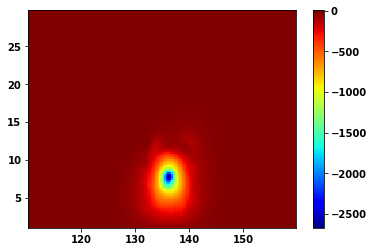

In [46]:
plot = plt.pcolor(lons[latIdx], lats[latIdx], typhoonWGeo, cmap = "jet")

plt.colorbar(plot)

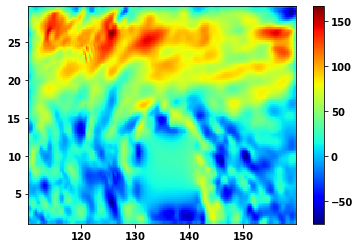

In [47]:
plot = plt.pcolor(lons[latIdx], lats[latIdx], typhoonWOGeo, cmap = "jet")

plt.colorbar(plot)